In [141]:
import os.path
import pickle
import pandas as pd
from torch.nn.functional import embedding

In [142]:
DATA_DIR = '/Users/ashfaq/Documents/traces/filtered_data_files'

dfs = [pd.read_parquet(os.path.join(DATA_DIR, f'data_{i}.parquet')) for i in range(3)]
combined_df = pd.concat(dfs, ignore_index=True)

In [143]:
combined_df['pair'] = combined_df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = combined_df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

In [144]:
unique_nodes = pd.unique(pd.concat([combined_df['u'], combined_df['i']]))
nodes = unique_nodes.tolist()

In [145]:
with open("data/all_embeddings.pkl", "rb") as file:
    embedding_dict = pickle.load(file)

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [147]:
node_id_encoder = LabelEncoder()
node_id_encoder.fit(list(embedding_dict.keys()))

LabelEncoder()

In [148]:
embeddings = np.array([embedding_dict[node_id] for node_id in node_id_encoder.classes_])

In [149]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)

In [150]:
from sklearn.metrics import silhouette_score

k_values = range(2, 30)

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
    
best_k_silhouette = k_values[np.argmax(silhouette_scores)]

In [151]:
kmeans = KMeans(n_clusters=best_k_silhouette, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

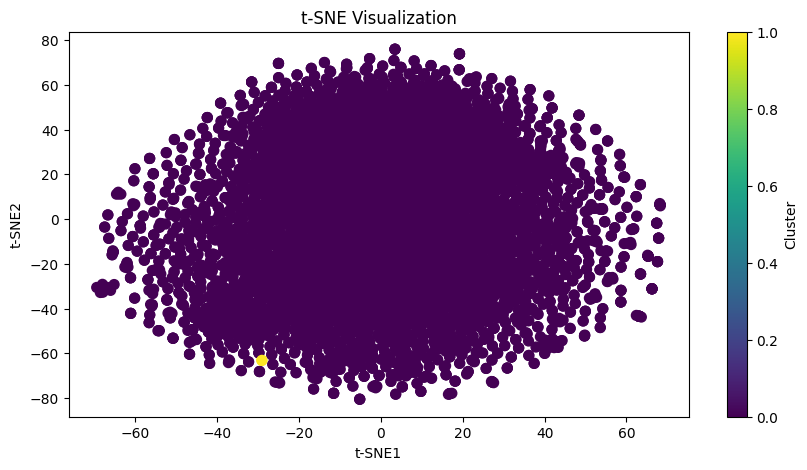

In [152]:
plt.figure(figsize=(10, 5))

plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label="Cluster")

plt.savefig('plots/tsne_embedding_visualization_skipgram.png')
plt.show()

In [153]:
import random
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict, num_samples=10_000):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    num_samples = min(num_samples, len(filtered_pairs))
    sampled_pairs = random.sample(filtered_pairs, num_samples)
    
    distances = []
    interaction_strengths = []
    
    for i, j in sampled_pairs:
        dist = euclidean(embedding_dict[i], embedding_dict[j])
        distances.append(dist)
        
        interaction_strengths.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(distances, interaction_strengths)
    spearman_corr, _ = spearmanr(distances, interaction_strengths)
    
    return distances, interaction_strengths, pearson_corr, spearman_corr

In [154]:
distances, interaction_strengths, pearson_corr, spearman_corr = validate_embeddings(embedding_dict, interaction_dict)

In [155]:
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: -0.04196245511587986
Spearman Correlation: -0.5478822551097078


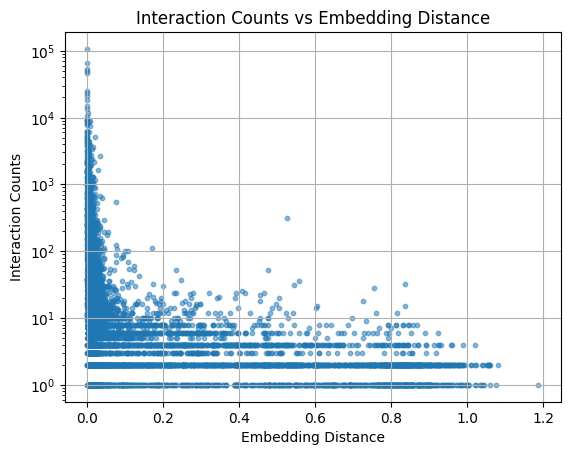

In [156]:
import matplotlib.pyplot as plt

plt.scatter(distances, interaction_strengths, alpha=0.5, s=10)
plt.title("Interaction Counts vs Embedding Distance")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/embedding_distrib_vs_interaction_count_skipgram.png')
plt.show()